In [264]:
import pandas as pd
import numpy as np
import pickle

We import the data from the pickle file as JSON:

In [265]:
data_json = pd.read_pickle('summoner_stats.pkl')

## Dataframes generation

We will generate two raw dataframe: one of them will contain the preffered champion statdistics and the other one the stadistics for all champions.

In [266]:
def build_dataframes(json):
    pref_list = []
    total_list = []
    for index in json:
        pref_dict = json[index]['pref_champ']['stats']
        pref_dict['summID'] = index
        pref_dict['champID'] = json[index]['pref_champ']['id']
        pref_list.append(pref_dict)
        total_dict = json[index]['total']['stats']
        total_dict['summID'] = index
        total_list.append(total_dict)
    df_pc = pd.DataFrame(pref_list).set_index('summID')
    df_total = pd.DataFrame(total_list).set_index('summID')
    return df_pc, df_total

In [267]:
df_pc, df_total = build_dataframes(data_json)

We inspect the columns for the 'Preferred champion" dataframe. We also set the "Summoner ID" as the index. 

In [268]:
print(df_pc.columns)
df_pc.head()

Index(['champID', 'maxChampionsKilled', 'maxNumDeaths',
       'mostChampionKillsPerSession', 'mostSpellsCast', 'totalAssists',
       'totalChampionKills', 'totalDamageDealt', 'totalDamageTaken',
       'totalDeathsPerSession', 'totalDoubleKills', 'totalFirstBlood',
       'totalGoldEarned', 'totalMagicDamageDealt', 'totalMinionKills',
       'totalPentaKills', 'totalPhysicalDamageDealt', 'totalQuadraKills',
       'totalSessionsLost', 'totalSessionsPlayed', 'totalSessionsWon',
       'totalTripleKills', 'totalTurretsKilled', 'totalUnrealKills'],
      dtype='object')


,champID,maxChampionsKilled,maxNumDeaths,mostChampionKillsPerSession,mostSpellsCast,totalAssists,totalChampionKills,totalDamageDealt,totalDamageTaken,totalDeathsPerSession,...,totalMinionKills,totalPentaKills,totalPhysicalDamageDealt,totalQuadraKills,totalSessionsLost,totalSessionsPlayed,totalSessionsWon,totalTripleKills,totalTurretsKilled,totalUnrealKills
summID,,,,,,,,,,,,,,,,,,,,,
35135373,64,15,13,15,0,708,460,8353064,2171770,425,...,3580,0,5848121,0,45,72,27,2,38,0
41656873,157,30,16,30,0,1269,1670,30015588,3730532,1239,...,32255,1,23109881,9,79,169,90,49,243,0
72630551,53,11,15,11,0,1687,247,4058477,3140435,959,...,2597,0,954246,0,62,118,56,0,24,0
32592979,103,21,12,21,0,382,317,6014660,776601,171,...,7717,0,739036,1,14,39,25,7,33,0
52162849,119,31,13,31,0,784,928,20210309,2018028,556,...,20061,2,20112185,7,46,104,58,28,156,0


We reorder the columns and drop some of them like the 0 value stats (deprecated data from the Riot API) and unrelevant data ('unreal kills', 'games against IA', etc..)

In [269]:
df_pc = df_pc[['champID', 'totalSessionsPlayed', 'totalSessionsWon', 'totalSessionsLost', 'totalGoldEarned', 
               'totalMinionKills', 'totalTurretsKilled', 'totalPhysicalDamageDealt', 'totalMagicDamageDealt', 
               'totalDamageTaken', 'totalDeathsPerSession', 'maxNumDeaths', 'totalAssists', 'totalChampionKills', 'totalDoubleKills', 
               'totalTripleKills', 'totalQuadraKills', 'totalPentaKills', 'mostChampionKillsPerSession']]
print(df_pc.dtypes)
df_pc.head()

champID                        int64
totalSessionsPlayed            int64
totalSessionsWon               int64
totalSessionsLost              int64
totalGoldEarned                int64
totalMinionKills               int64
totalTurretsKilled             int64
totalPhysicalDamageDealt       int64
totalMagicDamageDealt          int64
totalDamageTaken               int64
totalDeathsPerSession          int64
maxNumDeaths                   int64
totalAssists                   int64
totalChampionKills             int64
totalDoubleKills               int64
totalTripleKills               int64
totalQuadraKills               int64
totalPentaKills                int64
mostChampionKillsPerSession    int64
dtype: object


,champID,totalSessionsPlayed,totalSessionsWon,totalSessionsLost,totalGoldEarned,totalMinionKills,totalTurretsKilled,totalPhysicalDamageDealt,totalMagicDamageDealt,totalDamageTaken,totalDeathsPerSession,maxNumDeaths,totalAssists,totalChampionKills,totalDoubleKills,totalTripleKills,totalQuadraKills,totalPentaKills,mostChampionKillsPerSession
summID,,,,,,,,,,,,,,,,,,,
35135373,64,72,27,45,816970,3580,38,5848121,1758403,2171770,425,13,708,460,29,2,0,0,15
41656873,157,169,90,79,2220504,32255,243,23109881,6759421,3730532,1239,16,1269,1670,230,49,9,1,30
72630551,53,118,56,62,1093963,2597,24,954246,3001629,3140435,959,15,1687,247,6,0,0,0,11
32592979,103,39,25,14,510915,7717,33,739036,3578744,776601,171,12,382,317,43,7,1,0,21
52162849,119,104,58,46,1518463,20061,156,20112185,46069,2018028,556,13,784,928,128,28,7,2,31


In [270]:
print(df_pc.columns)
df_pc.head()

Index(['champID', 'totalSessionsPlayed', 'totalSessionsWon',
       'totalSessionsLost', 'totalGoldEarned', 'totalMinionKills',
       'totalTurretsKilled', 'totalPhysicalDamageDealt',
       'totalMagicDamageDealt', 'totalDamageTaken', 'totalDeathsPerSession',
       'maxNumDeaths', 'totalAssists', 'totalChampionKills',
       'totalDoubleKills', 'totalTripleKills', 'totalQuadraKills',
       'totalPentaKills', 'mostChampionKillsPerSession'],
      dtype='object')


,champID,totalSessionsPlayed,totalSessionsWon,totalSessionsLost,totalGoldEarned,totalMinionKills,totalTurretsKilled,totalPhysicalDamageDealt,totalMagicDamageDealt,totalDamageTaken,totalDeathsPerSession,maxNumDeaths,totalAssists,totalChampionKills,totalDoubleKills,totalTripleKills,totalQuadraKills,totalPentaKills,mostChampionKillsPerSession
summID,,,,,,,,,,,,,,,,,,,
35135373,64,72,27,45,816970,3580,38,5848121,1758403,2171770,425,13,708,460,29,2,0,0,15
41656873,157,169,90,79,2220504,32255,243,23109881,6759421,3730532,1239,16,1269,1670,230,49,9,1,30
72630551,53,118,56,62,1093963,2597,24,954246,3001629,3140435,959,15,1687,247,6,0,0,0,11
32592979,103,39,25,14,510915,7717,33,739036,3578744,776601,171,12,382,317,43,7,1,0,21
52162849,119,104,58,46,1518463,20061,156,20112185,46069,2018028,556,13,784,928,128,28,7,2,31


Now we perform the same actions for the 'All champions' dataframe.

In [271]:
df_total = df_total[['totalSessionsPlayed', 'totalSessionsWon', 'totalSessionsLost', 'totalGoldEarned', 
               'totalMinionKills', 'totalNeutralMinionsKilled', 'totalTurretsKilled', 'totalPhysicalDamageDealt', 
                'totalMagicDamageDealt', 'totalDamageTaken', 'totalHeal', 'totalDeathsPerSession', 'totalAssists', 
                'totalChampionKills', 'totalDoubleKills', 'totalTripleKills', 'totalQuadraKills', 'totalPentaKills']]
print(df_total.dtypes)
df_total.head()

totalSessionsPlayed          int64
totalSessionsWon             int64
totalSessionsLost            int64
totalGoldEarned              int64
totalMinionKills             int64
totalNeutralMinionsKilled    int64
totalTurretsKilled           int64
totalPhysicalDamageDealt     int64
totalMagicDamageDealt        int64
totalDamageTaken             int64
totalHeal                    int64
totalDeathsPerSession        int64
totalAssists                 int64
totalChampionKills           int64
totalDoubleKills             int64
totalTripleKills             int64
totalQuadraKills             int64
totalPentaKills              int64
dtype: object


,totalSessionsPlayed,totalSessionsWon,totalSessionsLost,totalGoldEarned,totalMinionKills,totalNeutralMinionsKilled,totalTurretsKilled,totalPhysicalDamageDealt,totalMagicDamageDealt,totalDamageTaken,totalHeal,totalDeathsPerSession,totalAssists,totalChampionKills,totalDoubleKills,totalTripleKills,totalQuadraKills,totalPentaKills
summID,,,,,,,,,,,,,,,,,,
35135373,468,237,231,5732460,66808,11109,442,43953696,19294367,12012974,1468098,3054,4046,3310,320,43,4,0
41656873,373,185,188,4393071,46628,4680,374,31823662,14401391,8186829,597955,2671,3433,2860,324,59,13,2
72630551,660,314,346,7326503,52379,13190,450,43792149,19692324,17969516,2564089,5271,6535,4453,397,54,8,4
32592979,110,65,45,1312977,17719,766,91,5091434,7108156,2340486,613654,498,1062,635,70,12,1,0
52162849,840,425,415,9654227,89093,15590,717,65150386,29735137,21860386,3436865,4892,8891,4610,409,58,10,2


## Data filtering and standarization by sessions played

We only consider the accounts that have 50 or more games played. 

In [272]:
df_pc = df_pc[df_pc.totalSessionsPlayed >= 50]
df_total = df_total[df_total.totalSessionsPlayed >= 50]

The "total" stadisitics are calculated as the sum of the totalSessionsPlayed so we must calculate the average data for all games.

In [273]:
df_pc['GoldEarned'] = df_pc['totalGoldEarned'] / df_pc['totalSessionsPlayed']
df_pc['MinionKills'] = df_pc['totalMinionKills'] / df_pc['totalSessionsPlayed']             
df_pc['PhysicalDamageDealt'] = df_pc['totalPhysicalDamageDealt'] / df_pc['totalSessionsPlayed']     
df_pc['MagicDamageDealt'] = df_pc['totalMagicDamageDealt'] / df_pc['totalSessionsPlayed']  
df_pc['DamageTaken'] = df_pc['totalDamageTaken'] / df_pc['totalSessionsPlayed']              
df_pc['DoubleKills'] = df_pc['totalDoubleKills'] / df_pc['totalSessionsPlayed']
df_pc['TripleKills'] = df_pc['totalTripleKills'] / df_pc['totalSessionsPlayed']
df_pc['QuadraKills'] = df_pc['totalQuadraKills'] / df_pc['totalSessionsPlayed']
df_pc['PentaKills'] = df_pc['totalPentaKills'] / df_pc['totalSessionsPlayed']
df_pc['TurretsKilled'] = df_pc['totalTurretsKilled'] / df_pc['totalSessionsPlayed']

df_total['GoldEarned'] = df_total['totalGoldEarned'] / df_total['totalSessionsPlayed']
df_total['MinionKills'] = df_total['totalMinionKills'] / df_total['totalSessionsPlayed']             
df_total['PhysicalDamageDealt'] = df_total['totalPhysicalDamageDealt'] / df_total['totalSessionsPlayed']     
df_total['MagicDamageDealt'] = df_total['totalMagicDamageDealt'] / df_total['totalSessionsPlayed']
df_total['DamageTaken'] = df_total['totalDamageTaken'] / df_total['totalSessionsPlayed']
df_total['DoubleKills'] = df_total['totalDoubleKills'] / df_total['totalSessionsPlayed']
df_total['TripleKills'] = df_total['totalTripleKills'] / df_total['totalSessionsPlayed']
df_total['QuadraKills'] = df_total['totalQuadraKills'] / df_total['totalSessionsPlayed']
df_total['PentaKills'] = df_total['totalPentaKills'] / df_total['totalSessionsPlayed']
df_total['TurretsKilled'] = df_total['totalTurretsKilled'] / df_total['totalSessionsPlayed']
df_total['Heal'] = df_total['totalHeal'] / df_total['totalSessionsPlayed']
df_total['NeutralMinionsKilled	'] = df_total['totalNeutralMinionsKilled'] / df_total['totalSessionsPlayed']

### KDA calculation

One important metric in competitive games as League of Legends is the KDA (Kills-Deaths-Assists) ratio. For a given player when can calculate the KDA for the ranked Season 5 as 
\begin{equation}
KDA = \frac{totalChampionKills + totalAssists}{totalDeathsPerSession} 
\end{equation}

In [274]:
df_pc['KDA'] = (df_pc['totalChampionKills'] + df_pc['totalAssists']) / df_pc['totalDeathsPerSession']

In [275]:
df_pc[['KDA', 'totalChampionKills', 'totalAssists', 'totalDeathsPerSession']].head()

,KDA,totalChampionKills,totalAssists,totalDeathsPerSession
summID,,,,
35135373,2.748235,460,708,425
41656873,2.372074,1670,1269,1239
72630551,2.016684,247,1687,959
52162849,3.079137,928,784,556
33893418,3.053284,1226,1238,807


In [276]:
df_total['totalKDA'] = (df_total['totalChampionKills'] + df_total['totalAssists']) / df_total['totalDeathsPerSession']

In [277]:
df_total[['totalKDA', 'totalChampionKills', 'totalAssists', 'totalDeathsPerSession']].head()

,totalKDA,totalChampionKills,totalAssists,totalDeathsPerSession
summID,,,,
35135373,2.408644,3310,4046,3054
41656873,2.356046,2860,3433,2671
72630551,2.084614,4453,6535,5271
32592979,3.407631,635,1062,498
52162849,2.759812,4610,8891,4892


### Win rate calculation

We calculate the Win Rate percentage per player for both dataframes (it will be the same as they are the same players).

In [278]:
df_pc['WinRate'] = df_pc['totalSessionsWon'] / df_pc['totalSessionsPlayed']

In [279]:
df_pc[['WinRate', 'totalSessionsPlayed', 'totalSessionsWon', 'totalSessionsLost']].head()

,WinRate,totalSessionsPlayed,totalSessionsWon,totalSessionsLost
summID,,,,
35135373,0.375000,72,27,45
41656873,0.532544,169,90,79
72630551,0.474576,118,56,62
52162849,0.557692,104,58,46
33893418,0.600000,165,99,66


In [280]:
df_total['WinRate'] = df_pc['totalSessionsWon'] / df_pc['totalSessionsPlayed']

In [281]:
df_total[['WinRate', 'totalSessionsPlayed', 'totalSessionsWon', 'totalSessionsLost']].head()

,WinRate,totalSessionsPlayed,totalSessionsWon,totalSessionsLost
summID,,,,
35135373,0.375000,468,237,231
41656873,0.532544,373,185,188
72630551,0.474576,660,314,346
32592979,NaN,110,65,45
52162849,0.557692,840,425,415


### Drop the unnecessary data

In [282]:
df_pc.drop(df_pc[['totalChampionKills', 'totalTurretsKilled', 'totalAssists', 'totalDeathsPerSession', 'totalSessionsPlayed', 'totalSessionsWon', 'totalSessionsLost', 'totalGoldEarned', 'totalMinionKills', 'totalPhysicalDamageDealt', 'totalMagicDamageDealt','totalDamageTaken', 'totalDoubleKills', 'totalTripleKills', 'totalQuadraKills', 'totalPentaKills']], axis=1, inplace=True)

In [283]:
df_total.drop(df_total[['totalHeal' ,'totalNeutralMinionsKilled','totalChampionKills', 'totalTurretsKilled', 'totalAssists', 'totalDeathsPerSession', 'totalSessionsPlayed', 'totalSessionsWon', 'totalSessionsLost', 'totalGoldEarned', 'totalMinionKills', 'totalPhysicalDamageDealt', 'totalMagicDamageDealt','totalDamageTaken', 'totalDoubleKills', 'totalTripleKills', 'totalQuadraKills', 'totalPentaKills']], axis=1, inplace=True)

## Dataframe description 

In [284]:
df_pc.head()

,champID,maxNumDeaths,mostChampionKillsPerSession,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,KDA,WinRate
summID,,,,,,,,,,,,,,,
35135373,64,13,15,11346.805556,49.722222,81223.902778,24422.263889,30163.472222,0.402778,0.027778,0.000000,0.000000,0.527778,2.748235,0.375000
41656873,157,16,30,13139.076923,190.857988,136744.857988,39996.573964,22074.153846,1.360947,0.289941,0.053254,0.005917,1.437870,2.372074,0.532544
72630551,53,15,11,9270.872881,22.008475,8086.830508,25437.533898,26613.855932,0.050847,0.000000,0.000000,0.000000,0.203390,2.016684,0.474576
52162849,119,13,31,14600.605769,192.894231,193386.394231,442.971154,19404.115385,1.230769,0.269231,0.067308,0.019231,1.500000,3.079137,0.557692
33893418,268,15,25,12807.842424,216.303030,13040.800000,153745.527273,17514.575758,0.806061,0.121212,0.018182,0.000000,1.193939,3.053284,0.600000


In [285]:
df_total.head()

,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,Heal,NeutralMinionsKilled,totalKDA,WinRate
summID,,,,,,,,,,,,,,
35135373,12248.846154,142.752137,93918.153846,41227.279915,25668.747863,0.683761,0.091880,0.008547,0.000000,0.944444,3136.961538,23.737179,2.408644,0.375000
41656873,11777.670241,125.008043,85318.128686,38609.627346,21948.603217,0.868633,0.158177,0.034853,0.005362,1.002681,1603.096515,12.546917,2.356046,0.532544
72630551,11100.762121,79.362121,66351.740909,29836.854545,27226.539394,0.601515,0.081818,0.012121,0.006061,0.681818,3884.983333,19.984848,2.084614,0.474576
32592979,11936.154545,161.081818,46285.763636,64619.600000,21277.145455,0.636364,0.109091,0.009091,0.000000,0.827273,5578.672727,6.963636,3.407631,NaN
52162849,11493.127381,106.063095,77559.983333,35398.972619,26024.269048,0.486905,0.069048,0.011905,0.002381,0.853571,4091.505952,18.559524,2.759812,0.557692


### Mean, std, min, max and percentiles

In [286]:
df_pc.describe()

,champID,maxNumDeaths,mostChampionKillsPerSession,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,KDA,WinRate
count,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000
mean,129.801218,14.080107,19.850370,12216.020220,134.436875,85339.164293,42131.731470,24456.603584,0.749440,0.116402,0.017926,0.003194,1.058892,2.949593,0.560864
std,118.473488,2.617090,7.383947,1592.856051,74.726105,66946.307285,46917.969788,5640.796238,0.480776,0.109228,0.025079,0.007290,0.631414,0.755802,0.060342
min,1.000000,6.000000,2.000000,7312.767123,4.178571,1669.872814,32.338235,7345.445525,0.000000,0.000000,0.000000,0.000000,0.018519,0.969806,0.096491
25%,55.000000,12.000000,16.000000,11481.492985,50.883696,14934.486607,8583.085729,20346.008758,0.390339,0.027341,0.000000,0.000000,0.514240,2.444492,0.522727
50%,90.000000,14.000000,21.000000,12614.225000,166.396800,91480.589144,20241.579467,23642.234793,0.770472,0.095821,0.009709,0.000000,0.982507,2.836735,0.560976
75%,157.000000,16.000000,25.000000,13325.619728,199.236838,145539.535714,63368.043299,28005.381884,1.080000,0.175413,0.026936,0.001964,1.516726,3.309609,0.597922
max,432.000000,37.000000,54.000000,17377.960784,276.330827,278989.626866,230219.826923,52609.887500,3.112903,0.961039,0.266881,0.135593,3.586207,9.892157,0.862069


In [287]:
df_total.describe()

,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,Heal,NeutralMinionsKilled,totalKDA,WinRate
count,19683.000000,19683.000000,19683.000000,19683.000000,19683.000000,19683.000000,19683.000000,19683.000000,19683.000000,19683.000000,19683.000000,19683.000000,19683.000000,13794.000000
mean,11909.427778,131.359148,76124.593905,48449.266267,25120.378550,0.630127,0.090411,0.012788,0.002128,0.946104,4017.248069,20.273186,2.644708,0.560864
std,837.112530,34.906848,27547.161127,17851.958582,3011.295461,0.247654,0.053230,0.011494,0.003226,0.290918,1279.597639,10.489607,0.470853,0.060342
min,7953.090090,10.779956,3548.289760,438.508130,11588.130300,0.008715,0.000000,0.000000,0.000000,0.095890,827.818898,0.132653,0.749436,0.096491
25%,11458.351021,109.158663,58247.464797,36174.064001,23143.979640,0.467953,0.054149,0.005141,0.000000,0.756138,3212.964885,13.116384,2.326908,0.522727
50%,11995.101942,134.861601,76292.075123,46689.879786,25113.157810,0.622340,0.082718,0.010429,0.001106,0.935135,3814.795780,18.543173,2.588089,0.560976
75%,12456.555336,156.255675,93759.553371,58353.084319,27076.501644,0.780459,0.118082,0.017544,0.003175,1.119735,4561.627396,25.282384,2.897742,0.597922
max,16127.776423,267.146707,252527.516556,189481.002994,40111.350993,2.569106,0.760000,0.235294,0.071429,2.707692,26442.601307,96.158333,7.159737,0.862069


### Covariances and Correlation between features

In [288]:
df_pc.cov()

,champID,maxNumDeaths,mostChampionKillsPerSession,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,KDA,WinRate
champID,1.403597e+04,-11.352668,-279.016406,-6.523760e+04,-2.049199e+03,-6.701493e+05,-1.359436e+06,-6.953737e+04,-13.141680,-1.929646,-0.231708,-0.033709,-11.598740,6.145331,-0.834347
maxNumDeaths,-1.135267e+01,6.849161,6.467001,7.391419e+02,1.571112e+01,2.383954e+04,-1.617490e+03,2.721913e+03,0.316766,0.059549,0.010395,0.002013,0.179063,-1.202605,-0.019053
mostChampionKillsPerSession,-2.790164e+02,6.467001,54.522668,9.463598e+03,3.406716e+02,2.677221e+05,3.955962e+04,2.180475e+03,2.926640,0.547841,0.095016,0.018392,2.626640,-1.882879,0.043615
GoldEarned,-6.523760e+04,739.141858,9463.598174,2.537190e+06,8.983125e+04,7.284475e+07,1.030968e+07,7.217036e+05,629.531712,117.615210,20.336668,3.818845,724.707852,-305.779335,17.702061
MinionKills,-2.049199e+03,15.711120,340.671570,8.983125e+04,5.583991e+03,2.894154e+06,3.047567e+05,-8.715185e+04,24.380368,4.822704,0.851166,0.162451,36.852544,-16.322151,0.452822
PhysicalDamageDealt,-6.701493e+05,23839.544783,267722.096555,7.284475e+07,2.894154e+06,4.481808e+09,-1.793348e+09,3.867823e+07,19521.023695,3876.249651,719.086654,137.106367,32725.774339,-16448.540140,19.167789
MagicDamageDealt,-1.359436e+06,-1617.490336,39559.617686,1.030968e+07,3.047567e+05,-1.793348e+09,2.201296e+09,-6.774144e+06,216.738710,-243.198972,-99.972408,-22.166484,-6383.317472,3147.115191,393.589677
DamageTaken,-6.953737e+04,2721.913005,2180.474858,7.217036e+05,-8.715185e+04,3.867823e+07,-6.774144e+06,3.181858e+07,-219.967010,-78.044439,-18.172998,-4.073432,-313.605397,-1054.313071,-9.813714
DoubleKills,-1.314168e+01,0.316766,2.926640,6.295317e+02,2.438037e+01,1.952102e+04,2.167387e+02,-2.199670e+02,0.231146,0.047928,0.008951,0.001760,0.200534,-0.108108,0.005122
TripleKills,-1.929646e+00,0.059549,0.547841,1.176152e+02,4.822704e+00,3.876250e+03,-2.431990e+02,-7.804444e+01,0.047928,0.011931,0.002328,0.000474,0.040729,-0.020351,0.001148


In [289]:
df_pc.corr()

,champID,maxNumDeaths,mostChampionKillsPerSession,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,KDA,WinRate
champID,1.000000,-0.036615,-0.318948,-0.345701,-0.231468,-0.084494,-0.244567,-0.104053,-0.230721,-0.149115,-0.077985,-0.039031,-0.155051,0.068630,-0.116710
maxNumDeaths,-0.036615,1.000000,0.334654,0.177310,0.080337,0.136067,-0.013173,0.184381,0.251754,0.208316,0.158384,0.105503,0.108361,-0.607990,-0.120648
mostChampionKillsPerSession,-0.318948,0.334654,1.000000,0.804621,0.617412,0.541588,0.114189,0.052351,0.824400,0.679251,0.513098,0.341685,0.563375,-0.337385,0.097889
GoldEarned,-0.345701,0.177310,0.804621,1.000000,0.754707,0.683117,0.137952,0.080323,0.822050,0.676007,0.509091,0.328887,0.720563,-0.253994,0.184174
MinionKills,-0.231468,0.080337,0.617412,0.754707,1.000000,0.578526,0.086924,-0.206759,0.678617,0.590857,0.454186,0.298222,0.781053,-0.289000,0.100424
PhysicalDamageDealt,-0.084494,0.136067,0.541588,0.683117,0.578526,1.000000,-0.570951,0.102423,0.606503,0.530090,0.428299,0.280945,0.774192,-0.325082,0.004745
MagicDamageDealt,-0.244567,-0.013173,0.114189,0.137952,0.086924,-0.570951,1.000000,-0.025596,0.009608,-0.047456,-0.084964,-0.064811,-0.215473,0.088749,0.139023
DamageTaken,-0.104053,0.184381,0.052351,0.080323,-0.206759,0.102423,-0.025596,1.000000,-0.081110,-0.126668,-0.128463,-0.099063,-0.088050,-0.247298,-0.028832
DoubleKills,-0.230721,0.251754,0.824400,0.822050,0.678617,0.606503,0.009608,-0.081110,1.000000,0.912663,0.742402,0.502323,0.660587,-0.297513,0.176539
TripleKills,-0.149115,0.208316,0.679251,0.676007,0.590857,0.530090,-0.047456,-0.126668,0.912663,1.000000,0.849810,0.594760,0.590541,-0.246517,0.174243


In [290]:
df_total.cov()

,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,Heal,NeutralMinionsKilled,totalKDA,WinRate
GoldEarned,7.007574e+05,22114.022988,1.700848e+07,3.620698e+06,4.903137e+05,168.367641,31.723972,5.391898,0.989569,168.806842,-1.328186e+05,2712.298394,-51.743237,4.352768
MinionKills,2.211402e+04,1218.488038,6.263082e+05,1.223110e+05,-1.623223e+04,5.610834,1.094309,0.187758,0.034318,7.616892,-1.200473e+04,-71.248487,-1.825221,0.175970
PhysicalDamageDealt,1.700848e+07,626308.248772,7.588461e+08,-1.870168e+08,9.609571e+06,4657.746337,917.174924,162.442277,30.897429,6324.734069,-7.822454e+06,70838.747202,-2371.904434,42.329170
MagicDamageDealt,3.620698e+06,122310.989340,-1.870168e+08,3.186924e+08,4.848266e+06,160.049562,-19.143479,-11.508932,-3.668040,-651.700726,3.511107e+06,30737.251728,-173.145725,105.365577
DamageTaken,4.903137e+05,-16232.230349,9.609571e+06,4.848266e+06,9.067900e+06,19.533810,-6.161393,-2.251915,-0.515496,-32.459212,1.529148e+06,15716.112727,-685.432282,-2.924328
DoubleKills,1.683676e+02,5.610834,4.657746e+03,1.600496e+02,1.953381e+01,0.061333,0.012264,0.002194,0.000425,0.047080,-8.547503e+01,0.368811,-0.019429,0.001736
TripleKills,3.172397e+01,1.094309,9.171749e+02,-1.914348e+01,-6.161393e+00,0.012264,0.002833,0.000522,0.000102,0.009372,-1.728380e+01,0.045507,-0.002700,0.000393
QuadraKills,5.391898e+00,0.187758,1.624423e+02,-1.150893e+01,-2.251915e+00,0.002194,0.000522,0.000132,0.000025,0.001659,-3.125964e+00,0.005609,-0.000325,0.000070
PentaKills,9.895691e-01,0.034318,3.089743e+01,-3.668040e+00,-5.154957e-01,0.000425,0.000102,0.000025,0.000010,0.000317,-6.029497e-01,0.000767,-0.000042,0.000014
TurretsKilled,1.688068e+02,7.616892,6.324734e+03,-6.517007e+02,-3.245921e+01,0.047080,0.009372,0.001659,0.000317,0.084634,-7.471809e+01,-0.047377,-0.021264,0.001535


In [291]:
df_total.corr()

,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,Heal,NeutralMinionsKilled,totalKDA,WinRate
GoldEarned,1.000000,0.756786,0.737572,0.242283,0.194508,0.812136,0.711949,0.560394,0.366457,0.693162,-0.123994,0.308883,-0.131276,0.086494
MinionKills,0.756786,1.000000,0.651329,0.196277,-0.154424,0.649039,0.588945,0.467975,0.304769,0.750060,-0.268762,-0.194583,-0.111050,0.080770
PhysicalDamageDealt,0.737572,0.651329,1.000000,-0.380293,0.115844,0.682736,0.625490,0.513047,0.347701,0.789213,-0.221918,0.245152,-0.182867,0.024305
MagicDamageDealt,0.242283,0.196277,-0.380293,1.000000,0.090188,0.036201,-0.020146,-0.056090,-0.063696,-0.125485,0.153704,0.164142,-0.020599,0.093723
DamageTaken,0.194508,-0.154424,0.115844,0.090188,1.000000,0.026193,-0.038439,-0.065063,-0.053068,-0.037052,0.396847,0.497545,-0.483421,-0.015801
DoubleKills,0.812136,0.649039,0.682736,0.036201,0.026193,1.000000,0.930308,0.770907,0.531945,0.653464,-0.269724,0.141971,-0.166615,0.115783
TripleKills,0.711949,0.588945,0.625490,-0.020146,-0.038439,0.930308,1.000000,0.853473,0.596699,0.605199,-0.253753,0.081501,-0.107741,0.124932
QuadraKills,0.560394,0.467975,0.513047,-0.056090,-0.065063,0.770907,0.853473,1.000000,0.687639,0.496050,-0.212543,0.046519,-0.059992,0.108719
PentaKills,0.366457,0.304769,0.347701,-0.063696,-0.053068,0.531945,0.596699,0.687639,1.000000,0.338136,-0.146073,0.022669,-0.027491,0.082225
TurretsKilled,0.693162,0.750060,0.789213,-0.125485,-0.037052,0.653464,0.605199,0.496050,0.338136,1.000000,-0.200716,-0.015525,-0.155234,0.085331


In [252]:
import plotly.plotly as py
import plotly.graph_objs as go

py.sign_in('juanluismoralperez', 'MUMjWF4QwNy8AtZW6WUq')

trace1 = go.Scatter3d(
    x=df_pc.WinRate,
    y=df_pc.KDA,
    z=df_pc.WinRate,
    mode='markers',
    marker=dict(
        size=12,
        color=df_pc.champID,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')


High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~juanluismoralperez/0 or inside your plot.ly account where it is named '3d-scatter-colorscale'


## Data visualization by champion 

In [292]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [293]:
sns.set(style="whitegrid", color_codes=True)

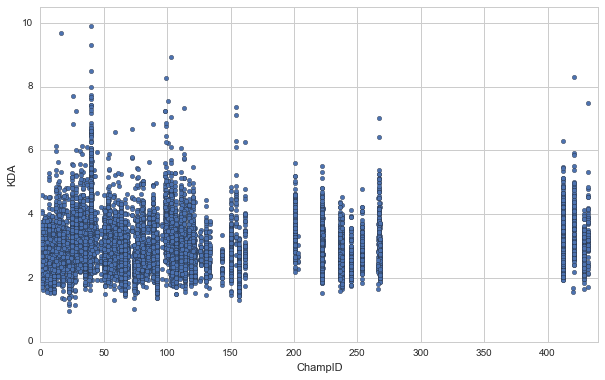

In [294]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df_pc['champID'], df_pc['KDA'])
plt.xlabel('ChampID')
plt.ylabel('KDA')
plt.xlim(0, 440)
plt.ylim(0, 10.5)
plt.show()

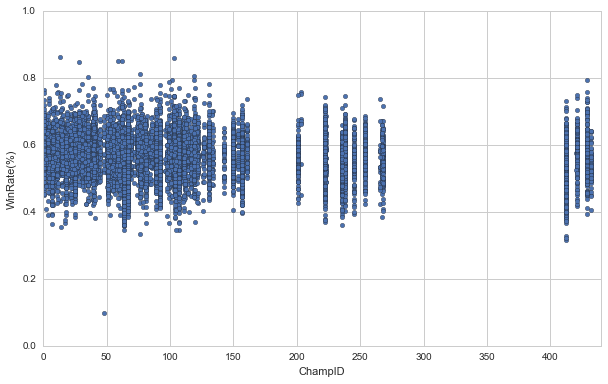

In [295]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df_pc['champID'], df_pc['WinRate'])
plt.xlabel('ChampID')
plt.ylabel('WinRate(%)')
plt.xlim(0, 440)
plt.ylim(0, 1)
plt.show()

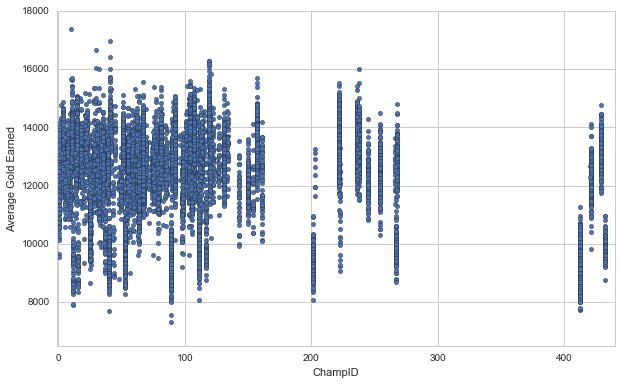

In [296]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df_pc['champID'], df_pc['GoldEarned'])
plt.xlabel('ChampID')
plt.ylabel('Average Gold Earned')
plt.xlim(-1, 440)
plt.ylim(6500, 18000)
plt.show()

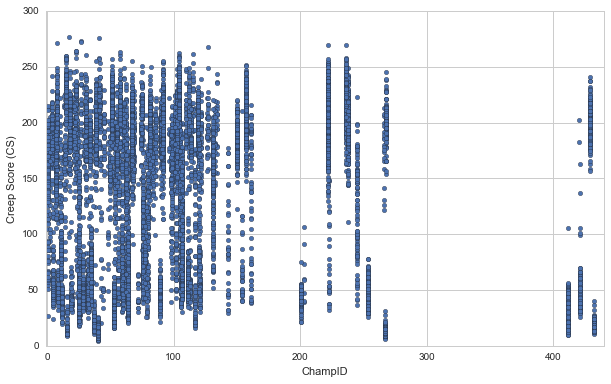

In [297]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.scatter(df_pc['champID'], df_pc['MinionKills'])
plt.xlabel('ChampID')
plt.ylabel('Creep Score (CS)')
plt.xlim(-1, 440)
plt.ylim(-0.05, 300)
plt.show()

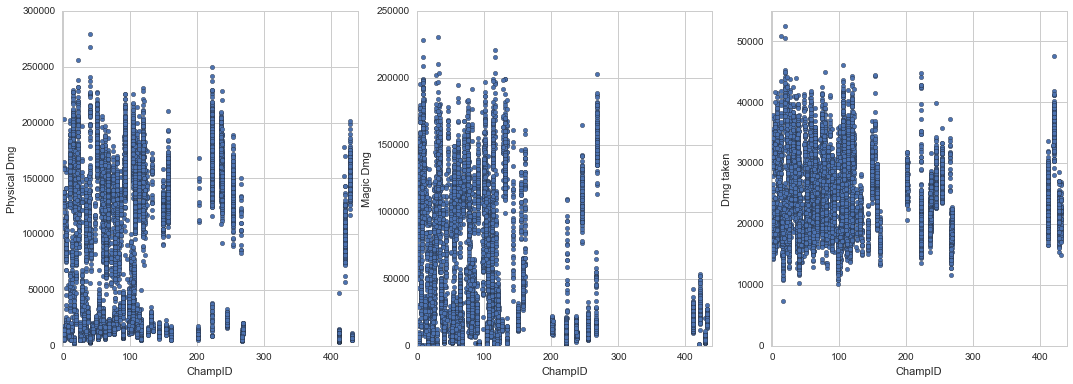

In [298]:
fig = plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(1,3,1)
ax1.scatter(df_pc['champID'], df_pc['PhysicalDamageDealt'])
ax2 = fig.add_subplot(1,3,2)
ax2.scatter(df_pc['champID'], df_pc['MagicDamageDealt'])
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(df_pc['champID'], df_pc['DamageTaken'])
ax1.set_xlim([-1, 440])
ax1.set_ylim([0, 300000])
ax1.set_xlabel('ChampID')
ax1.set_ylabel('Physical Dmg')
ax2.set_xlim([-1, 440])
ax2.set_ylim([0, 250000])
ax2.set_xlabel('ChampID')
ax2.set_ylabel('Magic Dmg')
ax3.set_xlim([-1, 440])
ax3.set_ylim([0, 55000])
ax3.set_xlabel('ChampID')
ax3.set_ylabel('Dmg taken')
plt.show()

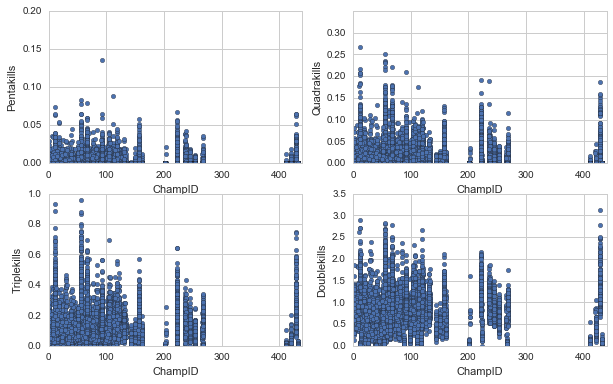

In [299]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(df_pc['champID'], df_pc['PentaKills'])
ax2 = fig.add_subplot(2,2,2)
ax2.scatter(df_pc['champID'], df_pc['QuadraKills'])
ax3 = fig.add_subplot(2,2,3)
ax3.scatter(df_pc['champID'], df_pc['TripleKills'])
ax4 = fig.add_subplot(2,2,4)
ax4.scatter(df_pc['champID'], df_pc['DoubleKills'])
ax1.set_xlim([-0.5, 440])
ax1.set_ylim([0, 0.2])
ax1.set_xlabel('ChampID')
ax1.set_ylabel('Pentakills')
ax2.set_xlim([-0.5, 440])
ax2.set_ylim([0, 0.35])
ax2.set_xlabel('ChampID')
ax2.set_ylabel('Quadrakills')
ax3.set_xlim([-0.5, 440])
ax3.set_ylim([0, 1])
ax3.set_xlabel('ChampID')
ax3.set_ylabel('Triplekills')
ax4.set_xlim([-0.5, 440])
ax4.set_ylim([0, 3.5])
ax4.set_xlabel('ChampID')
ax4.set_ylabel('Doublekills')
plt.show()

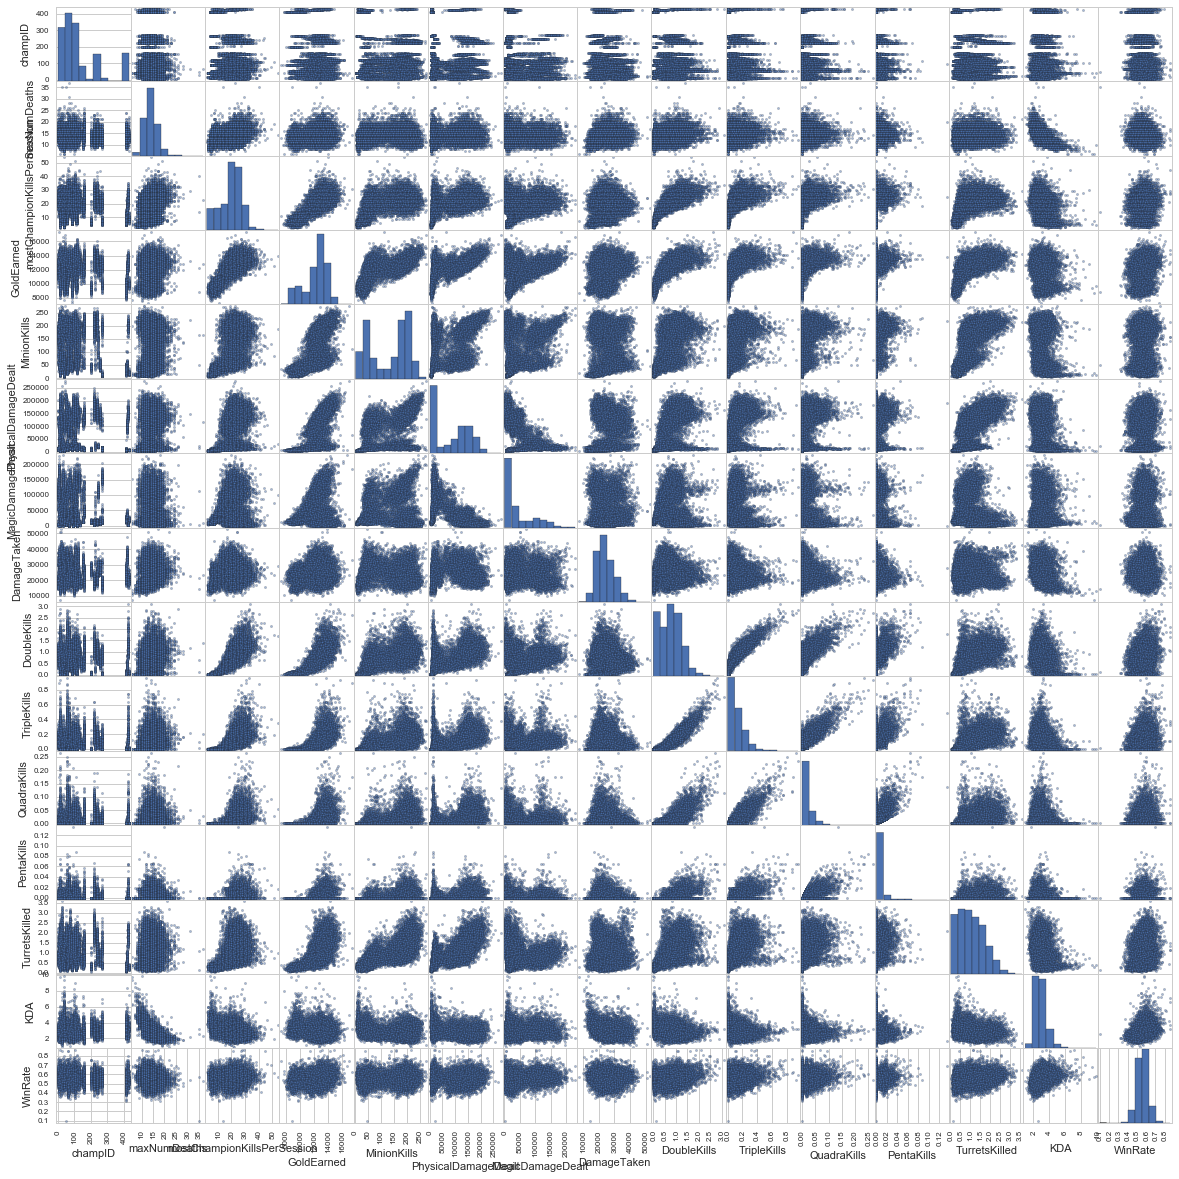

In [300]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df_pc, figsize = (20,20))
plt.show()

## Data visualization by player (all champions played)

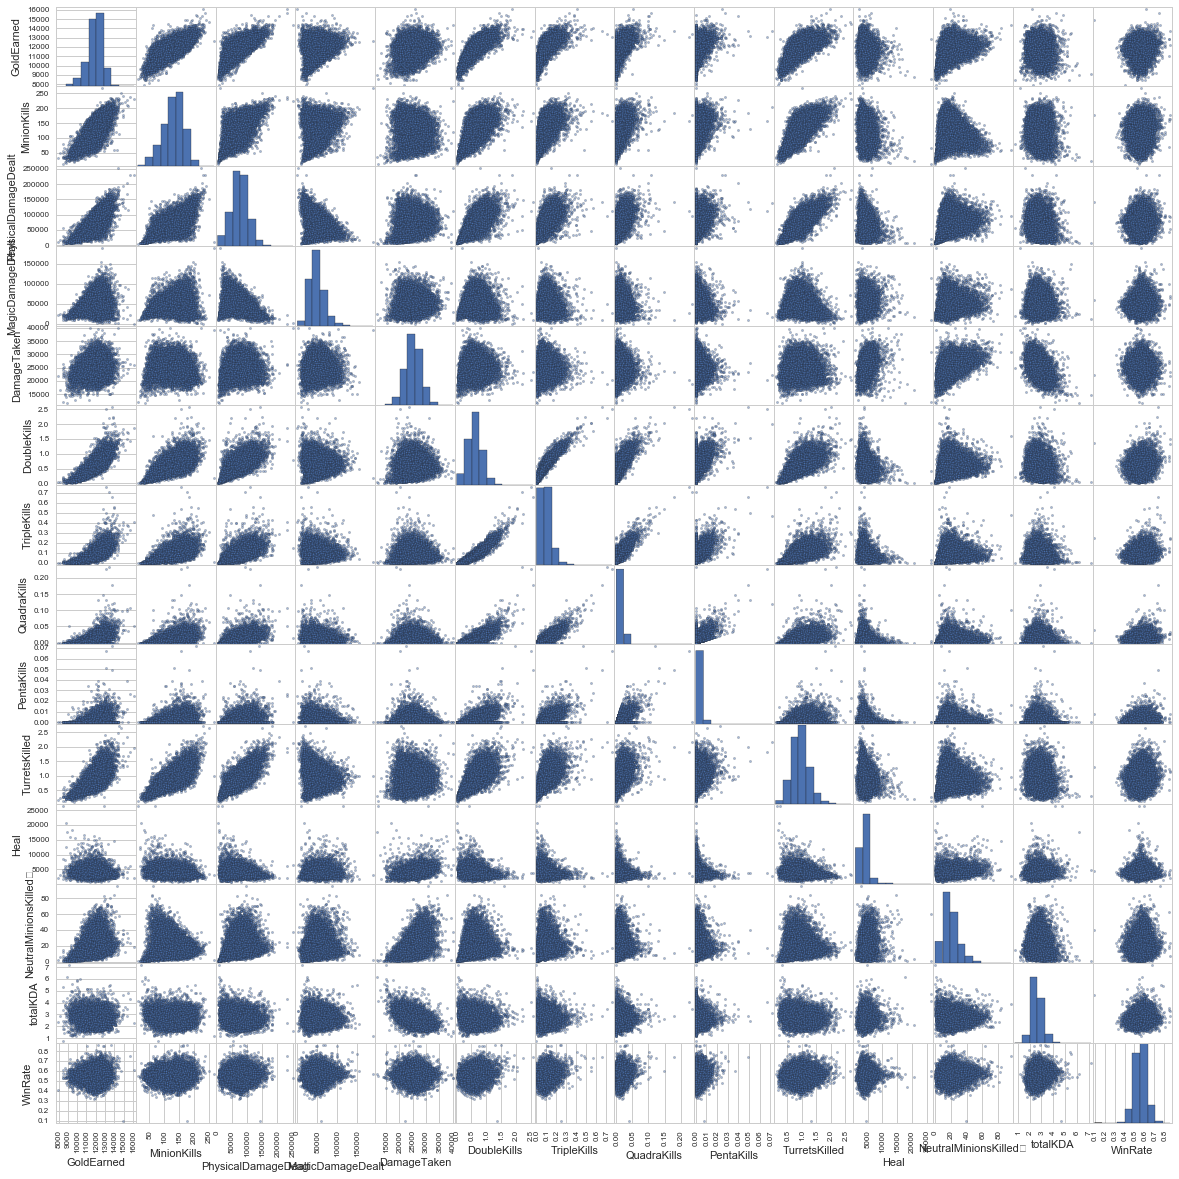

In [301]:
scatter_matrix(df_total, figsize = (20,20))
plt.show()